In [1]:
import os
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from textblob import TextBlob
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from urllib.parse import unquote
from scipy.special import softmax
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import BartTokenizer, BartForConditionalGeneration

In [2]:
load_dotenv()
api_token=os.getenv('HUGGINGFACEHUB_API_TOKEN')
os.environ['HF_TOKEN']=api_token
os.environ['HUGGINGFACEHUB_API_TOKEN']=api_token

In [3]:
def get_stock_sector(stock_symbol):
    try:
        stock = yf.Ticker(stock_symbol)
        info = stock.info
        sector = info.get('sector', 'Sector information not available')
        industry=info.get('industry','Industry information not available')        
        return sector,industry
    except Exception as e:
        print("Error:", e)
        return None

In [4]:
stock_symbol = input("Enter Stock Symbol: ")
sector,industry = get_stock_sector(stock_symbol)
if sector and industry:
    print("Stock:",stock_symbol)
    print("Sector:", sector)
    print('Industry:',industry)
elif sector:
    print("Stock:",stock_symbol)
    print("Sector:", sector)
    print('Industry:',"Falied to retrive industry information")
elif industry:
    print("Stock:",stock_symbol)
    print("Sector:", "Failed to retrieve sector information.")
    print('Industry:',industry)   
else:
    print("Failed to retrieve sector information.")

Stock: AAPL
Sector: Technology
Industry: Consumer Electronics


In [2]:
def scraping_article(url):
    headers = {
    'User-Agent': 'Your User Agent String',
    }
    r=requests.get(url,headers=headers)
    soup=BeautifulSoup(r.text,'html.parser')
    paragraphs=soup.find_all('p')
    text= [paragraph.text for paragraph in paragraphs]
    words=' '.join(text).split(' ')
    article = ' '.join(words)
    return article

In [3]:
def find_url(keyword):
    
    root = "https://www.google.com/"
    search_query = keyword.replace(" ", "+")
    link = f"https://www.google.com/search?q={search_query}&tbm=nws"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(link, headers=headers)
    webpage = response.content
    soup = BeautifulSoup(webpage, 'html5lib')
    links = []
    for div_tag in soup.find_all('div', class_='Gx5Zad'):
        a_tag = div_tag.find('a')
        if a_tag:
            if 'href' in a_tag.attrs:
                href = a_tag['href']
                if href.startswith('/url?q='):
                    url = href.split('/url?q=')[1].split('&sa=')[0]
                    links.append(url)
    return links    

In [4]:
def to_chunks(data):
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=3000,
        chunk_overlap=50
    )
    docs=text_splitter.split_text(data)
    return docs

In [5]:
def load_bart_model(model_name="facebook/bart-large-cnn"):
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)
    return tokenizer, model

In [6]:
def find_news_url(keyword, start_date, end_date):
    root = "https://www.google.com/"
    search_query = keyword.replace(" ", "+")
    link = f"{root}search?q={search_query}&tbm=nws&tbs=cdr:1,cd_min:{start_date},cd_max:{end_date}"

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    response = requests.get(link, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    news_links = []

    for article in soup.select('div.SoaBEf'):
        link = article.select_one('a')
        if link and 'href' in link.attrs:
            url = link['href']
            if url.startswith('/url?q='):
                url = unquote(url.split('/url?q=')[1].split('&sa=')[0])
            news_links.append(url)

    return news_links

In [7]:
def summarize_text(tokenizer, model, text, max_chunk_length, summary_max_length):
    inputs = tokenizer(text, return_tensors="pt", max_length=max_chunk_length, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=summary_max_length, min_length=200, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [8]:
def summarize_article(url, model_name="facebook/bart-large-cnn"):
    data = scraping_article(url)
    chunks = to_chunks(data)
    # tokenizer, model=load_pegasus_model("google/pegasus-xsum")
    tokenizer, model = load_bart_model(model_name)
    summaries = []
    for chunk in chunks:
        chunk_text = chunk
        summary = summarize_text(tokenizer, model, chunk_text,3000,800)
        summaries.append(summary)
    concatenated_summaries = " ".join(summaries)
    #  Second summarization pass: Summarize the concatenated summaries
    intermediate_chunks = [concatenated_summaries[i:i+3000] for i in range(0, len(concatenated_summaries), 3000)]
    final_summaries = []
    for intermediate_chunk in intermediate_chunks:
        final_summary = summarize_text(tokenizer, model, intermediate_chunk,3000,800)
        final_summaries.append(final_summary)    
    final_summary_text = " ".join(final_summaries)    
    return final_summary_text

In [15]:
url=find_url('elon musk')[0]
url="https://www.hrkatha.com/global-hr-news/tesla-to-lay-off-601-more-employees-amidst-market-challenges/"
summary = summarize_article(url)
print(summary)

Elon Musk, CEO, Tesla, first disclosed the intention to reduce the company’s workforce by over 10 per cent on 15 April. Since then, multiple rounds of layoffs have been executed, with Musk reportedly aiming for a 20 per cent reduction in headcount. The latest round of layoffs will primarily impact workers at Tesla's Palo Alto and Fremont facilities. The termination process set to commence within a 14-day period starting 20 June, 2024, according to the Worker Adjustment and Retraining Notification (WARN) notice issued by Tesla. Last month, Tesla announced plans to cut 6,020 jobs in California and Texas as part of its broader downsizing strategy. The move also aligns with broader trends in the tech and automotive industries, where companies prioritise cost management and operational efficiency. For Tesla, maintaining market leadership requires a balance between innovation and financial prudence. The company says it is committed to being a leader in the electric-vehicle industry and will 

In [12]:
def senti_model(model_name="cardiffnlp/twitter-roberta-base-sentiment"):
    tokenizer=AutoTokenizer.from_pretrained(model_name)
    model=AutoModelForSequenceClassification.from_pretrained(model_name)
    return tokenizer,model

In [13]:
def find_senti(news_texts):
    tokenizer,model=senti_model()
    encoded=tokenizer(news_texts,return_tensors='pt',truncation=True, padding=True, max_length=512)
    output=model(**encoded)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    weights = {
        'neg': -1,
        'neu': 0,
        'pos': 1
    }
    probabilities = {
        'neg': scores[0],
        'neu': scores[1],
        'pos': scores[2]
    }
    compound_score = sum(probabilities[label] * weights[label] for label in probabilities)
    senti_dict={
        'neg':scores[0],
        'neu': scores[1],
        'pos': scores[2],
        'polarity':compound_score        
    }
    return senti_dict


In [14]:
def subjectivity_analysis(text):
    blob = TextBlob(text)
    subjectivity = blob.sentiment.subjectivity
    return subjectivity

def relevance_scoring(summary, stock_name, domain_keywords):
    relevance_score = sum(1 for word in domain_keywords if word in summary) + (stock_name in summary)
    return relevance_score

def urgency_scoring(summary):
    # Look for time-sensitive words or phrases in the summary
    urgency_keywords = ['breaking', 'urgent', 'immediate']
    urgency_score = sum(1 for word in urgency_keywords if word in summary)
    return urgency_score

def mention_count(summary, stock_name, domain_keywords):
    # Count how many times the stock name and domain keywords appear in the summary
    count = sum(summary.count(word) for word in domain_keywords) + summary.count(stock_name)
    return count


In [15]:
def senti_find(news_texts):
    from nltk.sentiment import SentimentIntensityAnalyzer
    sia=SentimentIntensityAnalyzer()
    senti =sia.polarity_scores(news_texts)
    return senti

In [16]:
def extract_features(summary):
    # # Sentiment analysis
    sentiment_scores = find_senti(summary)
    subjectivity_score = subjectivity_analysis(summary)
    
    # # Financial analysis
    # relevance_score = relevance_scoring(summary, stock_name, domain_keywords)
    # urgency_score = urgency_scoring(summary)
    # mention_count_score = mention_count(summary, stock_name, domain_keywords)
    
    # Construct feature vector
    features = {
        'compound_sentiment_score': sentiment_scores['polarity'],
        'subjectivity_score': subjectivity_score,
        # 'relevance_score': relevance_score,
        # 'urgency_score': urgency_score,
        # 'mention_count': mention_count_score,
        'negative_sentiment_score': sentiment_scores['neg'],
        'neutral_sentiment_score': sentiment_scores['neu'],
        'positive_sentiment_score': sentiment_scores['pos']
    }
    
    return features
# def extract_features(summary):
#     # Sentiment analysis
#     sentiment_scores = senti_find(summary)
    
#     # Construct feature vector
#     features = {
#         'compound_sentiment_score': sentiment_scores['compound'],
#         'negative_sentiment_score': sentiment_scores['neg'],
#         'neutral_sentiment_score': sentiment_scores['neu'],
#         'positive_sentiment_score': sentiment_scores['pos']
#     }
    
#     return features


In [22]:
scores=extract_features(summary,"tesla","technology")
print(scores)

c:\Users\utkar\Desktop\DG_liger\Project\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'compound_sentiment_score': 0.18036261200904846, 'subjectivity_score': 0.28750000000000003, 'relevance_score': 10, 'urgency_score': 0, 'mention_count': 470, 'negative_sentiment_score': 0.08230248, 'neutral_sentiment_score': 0.65503246, 'positive_sentiment_score': 0.2626651}


In [17]:
df=pd.read_csv("tesla_dataset.csv")
df.drop(df.columns[df.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Article 1    0
Article 2    0
Article 3    0
Article 4    0
Article 5    0
dtype: int64

In [18]:
df.describe()

,Open,High,Low,Close,Volume
count,101.000000,101.000000,101.000000,101.000000,1.010000e+02
mean,185.918713,189.281683,182.276139,185.706337,1.005000e+08
std,21.942830,21.760230,21.532013,21.562290,2.663535e+07
min,140.560000,144.440000,138.800000,142.050000,5.981220e+07
25%,172.910000,175.790000,170.010000,172.820000,8.303400e+07
50%,182.000000,184.590000,177.110000,180.010000,9.700000e+07
75%,194.000000,198.870000,190.610000,194.050000,1.110000e+08
max,250.080000,251.250000,244.410000,248.420000,2.440000e+08


In [19]:
df['Movement'] = (df['Close'] - df['Open'] > 0).astype(int)
df.head()

,Date,Open,High,Low,Close,Volume,Article 1,Article 2,Article 3,Article 4,Article 5,Movement
0,02-01-2024,250.08,251.25,244.41,248.42,105000000.0,"Tesla delivered 461,538 Model 3 and Model Y ve...","The Austin, Texas, company said Tuesday that i...",Tesla reported record quarterly sales in the f...,Tesla set a new delivery record for the fourth...,Tesla confirmed it had been eclipsed by Chines...,0
1,03-01-2024,244.98,245.68,236.32,238.45,121000000.0,BYD says its annual EV sales rose 73% in 2023 ...,Porsche Taycan has set a lap time of 7:07.55 a...,New Tesla vehicles are starting to get banned ...,China's BYD has overtaken US electric vehicle ...,"Tesla sold 484,507 vehicles in Q4 – up 20% on ...",0
2,04-01-2024,239.25,242.70,237.73,237.93,103000000.0,BYD says its annual EV sales rose 73% in 2023 ...,Tesla announced it was venturing into auto ins...,China's BYDiBYDBYD Auto is a Chinese carmaker ...,The electric car manufacturer BYD sold more th...,Tesla announced it was venturing into auto ins...,0
3,05-01-2024,236.86,240.12,234.90,237.49,92379400.0,Samsung has established a service integration ...,Tesla is recalling 1.6 million vehicles in Chi...,Samsung has established a service integration ...,Cars reportedly have problems with automatic a...,Gujarat state minister Balvantsinh Rajput said...,1
4,08-01-2024,236.14,241.25,235.30,240.45,85166600.0,Samsung has established a service integration ...,Tesla has released an application programming ...,The Wall Street Journal reports Musk has used ...,Reports claim Tesla is preparing to launch a n...,Elon Musk’s reported drug use has left Tesla I...,1


In [20]:
df.value_counts("Movement")

Movement
0    55
1    46
Name: count, dtype: int64

In [22]:
compound_sentiment_scores = []
negative_sentiment_scores = []
neutral_sentiment_scores = []
positive_sentiment_scores = []
subjectivity_score=[]

In [23]:
for idx, row in df.iterrows():
    articles = [row[f'Article {i}'] for i in range(1, 6)]
    
    # Initialize sums for aggregation
    compound_sentiment_sum = 0
    negative_sentiment_sum = 0
    neutral_sentiment_sum = 0
    positive_sentiment_sum = 0
    subjectivity_sum=0
    
    # Process each article
    for article in articles:
        features = extract_features(article)
        compound_sentiment_sum += features['compound_sentiment_score']
        negative_sentiment_sum += features['negative_sentiment_score']
        neutral_sentiment_sum += features['neutral_sentiment_score']
        positive_sentiment_sum += features['positive_sentiment_score']
        subjectivity_sum+=features['subjectivity_score']
    
    # Calculate averages and append to lists
    num_articles = len(articles)
    compound_sentiment_scores.append(compound_sentiment_sum / num_articles)
    negative_sentiment_scores.append(negative_sentiment_sum / num_articles)
    neutral_sentiment_scores.append(neutral_sentiment_sum / num_articles)
    positive_sentiment_scores.append(positive_sentiment_sum / num_articles)
    subjectivity_score.append(subjectivity_sum/num_articles)

# Add aggregated features to DataFrame
df['avg_compound_sentiment_score'] = compound_sentiment_scores
df['avg_negative_sentiment_score'] = negative_sentiment_scores
df['avg_neutral_sentiment_score'] = neutral_sentiment_scores
df['avg_positive_sentiment_score'] = positive_sentiment_scores
df['avg_subjectivity_score']=subjectivity_score

# Display the DataFrame
print(df)

c:\Users\utkar\Desktop\DG_liger\Project\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


           Date    Open    High     Low   Close       Volume  \
0    02-01-2024  250.08  251.25  244.41  248.42  105000000.0   
1    03-01-2024  244.98  245.68  236.32  238.45  121000000.0   
2    04-01-2024  239.25  242.70  237.73  237.93  103000000.0   
3    05-01-2024  236.86  240.12  234.90  237.49   92379400.0   
4    08-01-2024  236.14  241.25  235.30  240.45   85166600.0   
..          ...     ...     ...     ...     ...          ...   
96   20-05-2024  177.56  177.75  173.52  174.95   61727400.0   
97   21-05-2024  175.51  186.88  174.71  186.60  115000000.0   
98   22-05-2024  182.85  183.80  178.12  180.11   88313500.0   
99   23-05-2024  181.80  181.90  173.26  173.74   71975500.0   
100  24-05-2024  174.84  180.08  173.73  179.24   65479700.0   

                                             Article 1  \
0    Tesla delivered 461,538 Model 3 and Model Y ve...   
1    BYD says its annual EV sales rose 73% in 2023 ...   
2    BYD says its annual EV sales rose 73% in 2023 ...   

In [87]:
df['Sentiment'] = df['avg_compound_sentiment_score'].apply(lambda x: 'Positive' if x >0 else 'Negative')
df.head()

,Date,Open,High,Low,Close,Volume,Article 1,Article 2,Article 3,Article 4,Article 5,Movement,avg_compound_sentiment_score,avg_negative_sentiment_score,avg_neutral_sentiment_score,avg_positive_sentiment_score,avg_subjectivity_score,Sentiment
0,02-01-2024,250.08,251.25,244.41,248.42,105000000.0,"Tesla delivered 461,538 Model 3 and Model Y ve...","The Austin, Texas, company said Tuesday that i...",Tesla reported record quarterly sales in the f...,Tesla set a new delivery record for the fourth...,Tesla confirmed it had been eclipsed by Chines...,0,0.478980,0.055119,0.410782,0.534099,0.360856,Positive
1,03-01-2024,244.98,245.68,236.32,238.45,121000000.0,BYD says its annual EV sales rose 73% in 2023 ...,Porsche Taycan has set a lap time of 7:07.55 a...,New Tesla vehicles are starting to get banned ...,China's BYD has overtaken US electric vehicle ...,"Tesla sold 484,507 vehicles in Q4 – up 20% on ...",0,0.287044,0.150987,0.410981,0.438031,0.356131,Positive
2,04-01-2024,239.25,242.70,237.73,237.93,103000000.0,BYD says its annual EV sales rose 73% in 2023 ...,Tesla announced it was venturing into auto ins...,China's BYDiBYDBYD Auto is a Chinese carmaker ...,The electric car manufacturer BYD sold more th...,Tesla announced it was venturing into auto ins...,0,0.224308,0.189255,0.397181,0.413564,0.404840,Positive
3,05-01-2024,236.86,240.12,234.90,237.49,92379400.0,Samsung has established a service integration ...,Tesla is recalling 1.6 million vehicles in Chi...,Samsung has established a service integration ...,Cars reportedly have problems with automatic a...,Gujarat state minister Balvantsinh Rajput said...,1,0.339286,0.124324,0.412066,0.463610,0.343837,Positive
4,08-01-2024,236.14,241.25,235.30,240.45,85166600.0,Samsung has established a service integration ...,Tesla has released an application programming ...,The Wall Street Journal reports Musk has used ...,Reports claim Tesla is preparing to launch a n...,Elon Musk’s reported drug use has left Tesla I...,1,0.363527,0.083790,0.468893,0.447317,0.445466,Positive


In [98]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb:.2f}")
print("\nXGBoost Model Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Hyperparameter tuning with GridSearchCV for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                               param_grid=param_grid_xgb,
                               cv=5,
                               n_jobs=-1,
                               verbose=2)

grid_search_xgb.fit(X_train_scaled, y_train)

print("\nBest parameters for XGBoost:", grid_search_xgb.best_params_)

# Use the best model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)

print("\nBest XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_xgb):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))


XGBoost Model Accuracy: 0.48

XGBoost Model Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.71      0.48         7
           1       0.71      0.36      0.48        14

    accuracy                           0.48        21
   macro avg       0.54      0.54      0.48        21
weighted avg       0.60      0.48      0.48        21

Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

Best XGBoost Model Performance:
Accuracy: 0.33

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         7
           1       0.00      0.00      0.00        14

    accuracy                           0.33        21
   macro avg       0.17      0.50      0.25        21
weighted avg       0.11      0.33      0.

c:\Users\utkar\Desktop\DG_liger\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\utkar\Desktop\DG_liger\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\utkar\Desktop\DG_liger\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [97]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Article 1',
       'Article 2', 'Article 3', 'Article 4', 'Article 5', 'Movement',
       'avg_compound_sentiment_score', 'avg_negative_sentiment_score',
       'avg_neutral_sentiment_score', 'avg_positive_sentiment_score',
       'avg_subjectivity_score', 'Sentiment'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

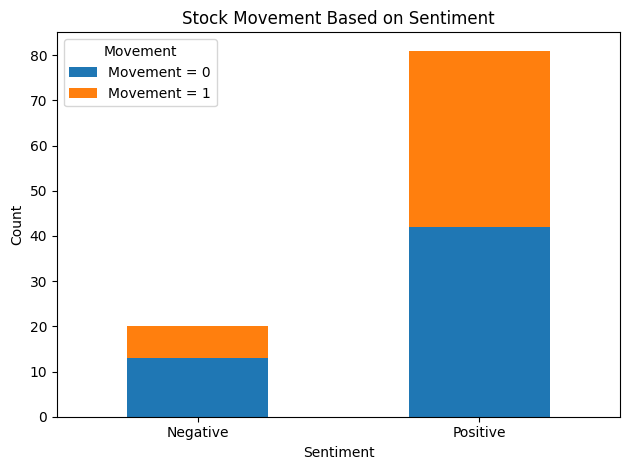

In [78]:
plt.figure(figsize=(10, 6))

# Group by Sentiment and Movement and count occurrences
plot_data = df.groupby(['Sentiment', 'Movement']).size().unstack(fill_value=0)

# Plotting the grouped data
plot_data.plot(kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Stock Movement Based on Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Movement', labels=['Movement = 0', 'Movement = 1'])
plt.tight_layout()

plt.show()

In [33]:
df_test=df.copy()

In [35]:
# df.to_csv("update.csv")

In [147]:
df_test.drop(["Sentiment"],axis=1,inplace=True)

In [168]:
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score <= 0:
        return 'Negative'
    else:
        return 'Neutral'

df_test['Sentiment'] = df_test['avg_compound_sentiment_score'].apply(categorize_sentiment)

<Figure size 1000x600 with 0 Axes>

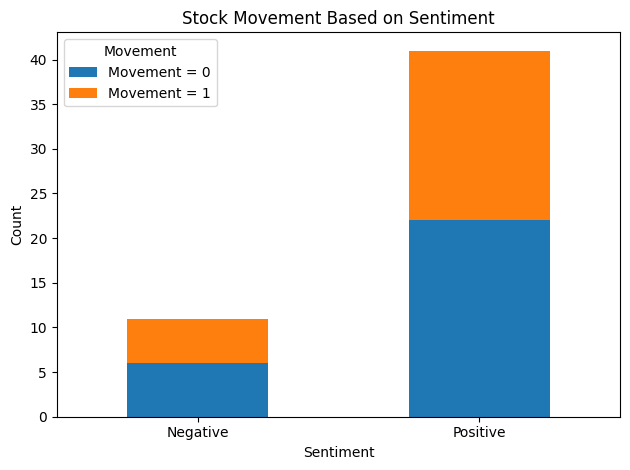

In [169]:
plt.figure(figsize=(10, 6))

# Group by Sentiment and Movement and count occurrences
plot_data = df_test.groupby(['Sentiment', 'Movement']).size().unstack(fill_value=0)

# Plotting the grouped data
plot_data.plot(kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Stock Movement Based on Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Movement', labels=['Movement = 0', 'Movement = 1'])
plt.tight_layout()

plt.show()

In [163]:
df.to_csv("no_neutral.csv")